<a href="https://colab.research.google.com/github/S1R3S1D/PINNxMICROFLUIDICS/blob/main/Laminar_Flow_PINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
import numpy as np

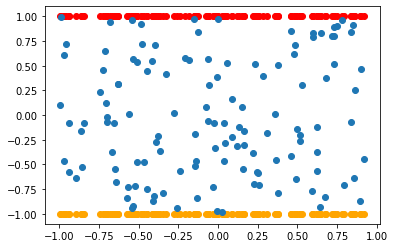

In [22]:
#Cloud Generator

domain_X = [-1, 1]
domain_Y = [-1, 1]

rng = np.random.default_rng(123)

def cloud(size=128):
  
  #interior
  X = rng.uniform(domain_X[0], domain_X[1], size)
  Y = rng.uniform(domain_Y[0], domain_Y[1], size)

  return (X, Y)

#Random Plotting in Domain
x, y = cloud(128)
plt.scatter(x, domain_Y[0]*np.ones_like(x), color='orange')
plt.scatter(x, domain_Y[1]*np.ones_like(x), color='red')
plt.scatter(x, y)
plt.show()

In [27]:
class NSFnet_VP(nn.Module):
  def __init__(self):
    super().__init__()

    self.FC1 = nn.Linear(2, 64)
    self.AC1 = nn.Tanh()

    self.FC2 = nn.Linear(64, 128)
    self.AC2 = nn.Tanh()

    self.FC3 = nn.Linear(128, 2)

  def forward(self, x):
    out = self.AC1(self.FC1(x))
    out = self.AC2(self.FC2(out))
    out = self.FC3(out)
    return out

In [28]:
model = NSFnet_VP()
lr=0.01
optimizer = torch.optim.Adam(model.parameters(), lr)
epochs = 20000

In [29]:
for epoch in tqdm(range(epochs)):

  #Data
  size = 128
  x_sample, y_sample = cloud(size)
  x_t = torch.tensor(x_sample, dtype=torch.float, requires_grad=True)
  y_t = torch.tensor(y_sample, dtype=torch.float, requires_grad=True)
  data = torch.stack([torch.cat([x_t, x_t, x_t], dim=0), torch.cat([y_t, domain_Y[0]*torch.ones_like(y_t), domain_Y[1]*torch.ones_like(y_t)])], dim=1)

  #PDE Predictions
  preds = model(data)
  u_preds = preds[:size, 0]#Velocity
  p_preds = preds[:size, 1]#Pressure

  #Differentials
  du_dx = torch.autograd.grad(u_preds, x_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  du_dy = torch.autograd.grad(u_preds, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]
  d2u_dy2 = torch.autograd.grad(du_dy, y_t, torch.ones_like(u_preds), create_graph=True, retain_graph=True)[0]

  dp_dx = torch.autograd.grad(p_preds, x_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]
  dp_dy = torch.autograd.grad(p_preds, y_t, torch.ones_like(p_preds), create_graph=True, retain_graph=True)[0]

  #Losses
  mu = 1

  #PDE_Loss
  loss = torch.sum(du_dx**2)
  loss = loss + torch.sum(dp_dy**2)
  loss = loss + torch.sum((dp_dx-100)**2)
  loss = loss + torch.sum((dp_dx-mu*(d2u_dy2))**2)
  loss_p = loss

  #Boundary Loss
  v = 1
  loss = torch.sum((preds[size:size*2,0])**2)
  loss = loss+torch.sum((preds[size*2:size*3,0])**2)
  loss_b = loss

  alpha_b = 0.0001

  #Total loss
  loss = loss_p + alpha_b*loss_b 

  if(epoch%1000==0 or epoch==9999):
    print("PDE Loss:", loss_p.item(), ", Boundary Loss:", loss_b.item())

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  0%|          | 10/20000 [00:00<03:25, 97.51it/s]

PDE Loss: 1276964.875 , Boundary Loss: 5.184422016143799


  5%|▌         | 1010/20000 [00:10<03:29, 90.69it/s]

PDE Loss: 883.324462890625 , Boundary Loss: 2482.367919921875


 10%|█         | 2018/20000 [00:21<03:14, 92.68it/s]

PDE Loss: 238.44053649902344 , Boundary Loss: 2139.928466796875


 15%|█▌        | 3010/20000 [00:33<03:02, 92.87it/s]

PDE Loss: 94.21733093261719 , Boundary Loss: 3081.04638671875


 20%|██        | 4020/20000 [00:44<02:50, 93.58it/s]

PDE Loss: 14.503013610839844 , Boundary Loss: 1186.2384033203125


 25%|██▌       | 5010/20000 [00:54<02:40, 93.12it/s]

PDE Loss: 104.69221496582031 , Boundary Loss: 2761.87255859375


 30%|███       | 6010/20000 [01:05<02:39, 87.45it/s]

PDE Loss: 350.2782287597656 , Boundary Loss: 1673.683837890625


 35%|███▌      | 7018/20000 [01:16<02:17, 94.10it/s]

PDE Loss: 289.98687744140625 , Boundary Loss: 1031.0283203125


 40%|████      | 8020/20000 [01:28<02:08, 92.97it/s]

PDE Loss: 164.661376953125 , Boundary Loss: 584.6210327148438


 45%|████▌     | 9010/20000 [01:38<02:01, 90.25it/s]

PDE Loss: 40.05944061279297 , Boundary Loss: 23.561840057373047


 50%|█████     | 10008/20000 [01:49<01:54, 86.96it/s]

PDE Loss: 42.68830871582031 , Boundary Loss: 46.772247314453125
PDE Loss: 27.256181716918945 , Boundary Loss: 63.692291259765625


 55%|█████▌    | 11017/20000 [02:00<01:34, 94.60it/s]

PDE Loss: 18.228546142578125 , Boundary Loss: 240.4926300048828


 60%|██████    | 12017/20000 [02:10<01:25, 93.52it/s]

PDE Loss: 2.4475088119506836 , Boundary Loss: 90.7630844116211


 65%|██████▌   | 13013/20000 [02:22<01:50, 63.00it/s]

PDE Loss: 4.015842437744141 , Boundary Loss: 27.204309463500977


 70%|███████   | 14012/20000 [02:33<01:03, 94.59it/s]

PDE Loss: 207.45278930664062 , Boundary Loss: 874.7371826171875


 75%|███████▌  | 15019/20000 [02:44<00:54, 90.85it/s]

PDE Loss: 91.04955291748047 , Boundary Loss: 42.82100296020508


 80%|████████  | 16015/20000 [02:54<00:43, 91.67it/s]

PDE Loss: 81.64012145996094 , Boundary Loss: 488.9143981933594


 85%|████████▌ | 17020/20000 [03:05<00:31, 93.99it/s]

PDE Loss: 13.281655311584473 , Boundary Loss: 308.0837707519531


 90%|█████████ | 18010/20000 [03:16<00:21, 93.45it/s]

PDE Loss: 359.5768737792969 , Boundary Loss: 1457.441650390625


 95%|█████████▌| 19013/20000 [03:28<00:10, 90.17it/s]

PDE Loss: 1.2914586067199707 , Boundary Loss: 32.02236557006836


100%|██████████| 20000/20000 [03:38<00:00, 91.47it/s]


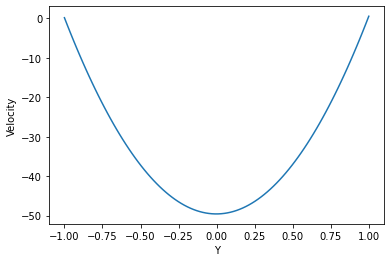

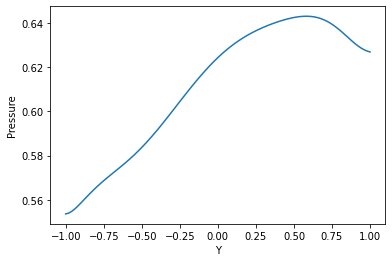

In [30]:
y = np.linspace(domain_Y[0], domain_Y[1], 100)
x = np.zeros_like(y)

x_t = torch.tensor(x, dtype=torch.float)
y_t = torch.tensor(y, dtype=torch.float)

with torch.no_grad():
  preds = model(torch.stack([x_t, y_t], dim=1))

u_preds = preds[:, 0].numpy()
p_preds = preds[:, 1].numpy()

plt.plot(y, u_preds,)
plt.xlabel('Y')
plt.ylabel('Velocity')
plt.show()

plt.plot(y, p_preds)
plt.xlabel('Y')
plt.ylabel('Pressure')
plt.show()